In [2]:
%matplotlib inline
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta as delta

In [3]:
dp = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S,%f")

l = pd.read_csv("./part-00000", sep="\t", header=None, names=("at", "level", "msg"), 
                index_col=["at"], parse_dates=["at"])
l.index = l.index.map(lambda x: x + delta(hours=8))
l = l.sort_index()
l.head()

,level,msg
at,,
2017-03-27 08:00:02.832,INFO,Found MAC: 00:15:04:07:D7:4B and SSID: Marshall
2017-03-27 08:00:05.482,INFO,Found MAC: 74:DE:2B:44:EB:B3 and SSID:
2017-03-27 08:00:05.835,INFO,Found MAC: 00:15:04:07:D7:4B and SSID: Marshall
2017-03-27 08:00:05.870,INFO,Found MAC: 00:9C:02:74:06:C2 and SSID: mingau
2017-03-27 08:00:05.969,INFO,Found MAC: 00:9C:02:74:06:C2 and SSID: mingau


In [4]:
pf = pd.read_csv("./phones-mac.csv", header=None, names=("prefix",))
pf.head()

,prefix
0,3C:D9:2B
1,9C:8E:99
2,B4:99:BA
3,1C:C1:DE
4,48:AD:08


In [5]:
import re
mac_pattern = re.compile("[0-9A-F]{2}:[0-9A-F]{2}:[0-9A-F]{2}:[0-9A-F]{2}:[0-9A-F]{2}:[0-9A-F]{2}")

log = l[l.msg.str.contains(mac_pattern)]
log['mac'] = log['msg'].map(lambda y: mac_pattern.search(y).group(0))
# Filter MAC address that are from a Phone manufacturer
p = log[log['mac'].str[0:8].isin(pf['prefix'])]
p = p['2017-03-27 08:20':'2017-03-27 10:00']
p.tail()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,level,msg,mac
at,,,
2017-03-27 09:22:12.490,INFO,Found MAC: 88:79:7E:D6:E8:21 and SSID:,88:79:7E:D6:E8:21
2017-03-27 09:22:12.512,INFO,Found MAC: 88:79:7E:D6:E8:21 and SSID:,88:79:7E:D6:E8:21
2017-03-27 09:22:12.543,INFO,Found MAC: 88:79:7E:D6:E8:21 and SSID:,88:79:7E:D6:E8:21
2017-03-27 09:22:12.592,INFO,Found MAC: 88:79:7E:D6:E8:21 and SSID:,88:79:7E:D6:E8:21
2017-03-27 09:22:12.647,INFO,Found MAC: 88:79:7E:D6:E8:21 and SSID:,88:79:7E:D6:E8:21


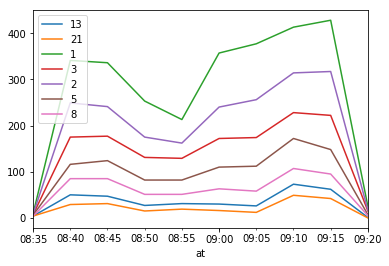

In [6]:
from pandas.tseries.offsets import DateOffset
from functools import partial


def repeated_n(data, times):
    c = data.value_counts()
    return c.where(c >= times).count()


fib = {"%s" % i: partial(repeated_n, times=i) for i in [1, 2, 3, 5, 8, 13, 21]}

p['mac'].resample('5min').agg(fib).plot()

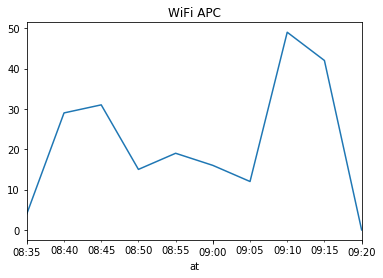

In [23]:
countr = partial(repeated_n, times=21)

c = p['mac'].resample('5min').agg({'count': countr})
c.plot(title="WiFi APC", legend=None)

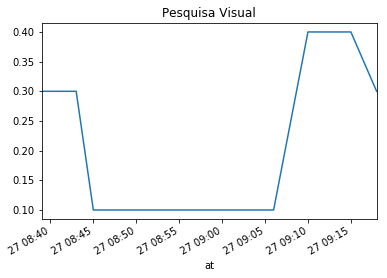

In [24]:
v = pd.read_csv("./visual-2017-03-27.csv",header=None, names=("at", "occ"), 
                index_col=["at"], parse_dates=["at"])
v.index = v.index.map(lambda x: x + delta(minutes=28))
v.plot(title="Pesquisa Visual", legend=None)

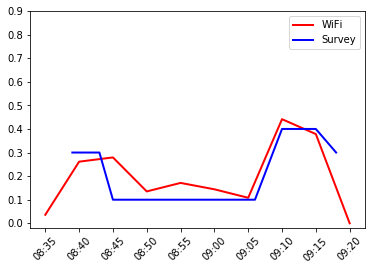

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import signal

BUS_MAX_OCC = 111

flatten = lambda l: [item for sublist in l for item in sublist]

x1 = c.index.tolist()
y1 = c['count'].map(lambda y: y / float(BUS_MAX_OCC))
yfilter = signal.medfilt(y1)
zfilter = signal.hilbert(y1)

# plt.plot(x, y, 'b', linewidth=0.2)
plt.plot(x1, zfilter, 'r', linewidth=2, label="WiFi")

# Ground truth
x2 = v.index.tolist()
y2 = v['occ'].tolist()
plt.plot(x2, y2, 'b-', linewidth=2, label="Survey")

# Adjust axis output
plt.legend()
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xticks(x1, [dt.strftime(xis, "%H:%M") for xis in x1], rotation=45)

plt.show()

In [15]:
import matplotlib.pyplot as plt
from scipy import stats

def find_nearest_true_value(value):
    after = v[value:]['occ'].tolist()
    before = v[:value]['occ'].tolist()
    
    if after:
        return after[0]
    elif before:
        return before[-1]
        

r = c.copy()
r['wifi'] = r['count'].map(lambda y: y / float(BUS_MAX_OCC))
r['truth'] = r.index.map(find_nearest_true_value)
r.head()

,count,wifi,truth
at,,,
2017-03-27 08:35:00,4,0.036036,0.3
2017-03-27 08:40:00,29,0.261261,0.3
2017-03-27 08:45:00,31,0.279279,0.1
2017-03-27 08:50:00,15,0.135135,0.1
2017-03-27 08:55:00,19,0.171171,0.1


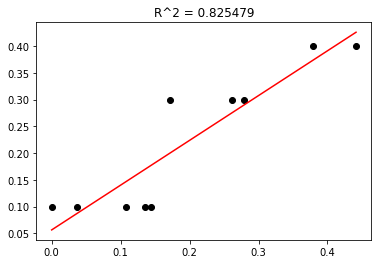

In [16]:
x = r['wifi'].sort_values()
y = r['truth'].sort_values()

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.plot(x, y, 'ko', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.title("R^2 = %f" % r_value ** 2)
plt.show()